In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette() # used to generate colors in seaborn
%matplotlib inline

In [3]:
# reading all files as pandas data frame
aisles=pd.read_csv("./aisles.csv")
departments=pd.read_csv("./departments.csv")
orders=pd.read_csv("./orders.csv")
products=pd.read_csv("./products.csv")
sample_submission=pd.read_csv("./sample_submission.csv")
order_products__prior=pd.read_csv("./order_products__prior.csv")
order_products__train=pd.read_csv("./order_products__train.csv")

In [4]:
aisles.head()
#aisle_id: aisle identifier
#aisle: the name of the aisle

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments.head()
#department_id: department identifier
#department: the name of the department

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
orders.head()
#order_id: order identifier
#user_id: customer identifier
#eval_set: which evaluation set this order belongs in 
#order_number: the order sequence number for this user 
#order_dow: the day of the week the order was placed on
#order_hour_of_day: the hour of the day the order was placed on
#days_since_prior: days since the last order, capped at 30 

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
products.head()
#product_id: product identifier
#product_name: name of the product
#aisle_id: foreign key
#department_id: foreign key

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [9]:
order_products__prior.head()
#"prior": orders prior to that users most recent order
#order_id: foreign key
#product_id: foreign key
#add_to_cart_order: order in which each product was added to cart
#reordered: 1 if this product has been ordered by this user in the past, 0 otherwise    


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
order_products__train.head()
#"train": training data supplied to participants
#order_id: foreign key
#product_id: foreign key
#add_to_cart_order: order in which each product was added to cart
#reordered: 1 if this product has been ordered by this user in the past, 0 otherwise    


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


We have to predict the products that will be re-ordered. So the last order of user has been divided into train and test sets. All prior order information of customer has been given in order_products__prior.csv 

In [11]:
# finding no. of observations in each dataset
count= orders.eval_set.value_counts()
print(count)

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


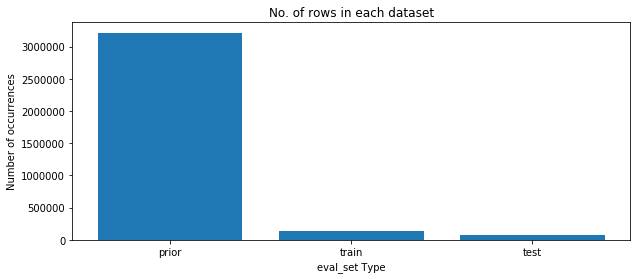

In [12]:
plt.figure(figsize=(10,4))
plt.bar(count.index,count.values)
plt.xlabel("eval_set Type")
plt.ylabel("Number of occurrences")
plt.title("No. of rows in each dataset")
plt.show()

In [13]:
def get_unique_counts(x):
    return len(np.unique(x))

In [14]:
cnt=orders.groupby("eval_set")["user_id"].aggregate(get_unique_counts)
print(cnt)

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64


So there are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

In [15]:
# finding frequency of orders on each day of week
count=orders.order_dow.value_counts()
print(count)

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64


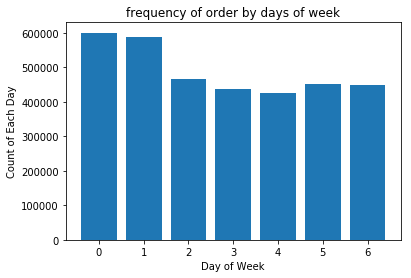

In [16]:
plt.bar(count.index,count.values)
plt.xlabel("Day of Week")
plt.ylabel("Count of Each Day")
plt.title("frequency of order by days of week")
plt.show()

In [17]:
count=orders.order_hour_of_day.value_counts()
print(count)

10    288418
11    284728
15    283639
14    283042
13    277999
12    272841
16    272553
9     257812
17    228795
18    182912
8     178201
19    140569
20    104292
7      91868
21     78109
22     61468
23     40043
6      30529
0      22758
1      12398
5       9569
2       7539
4       5527
3       5474
Name: order_hour_of_day, dtype: int64


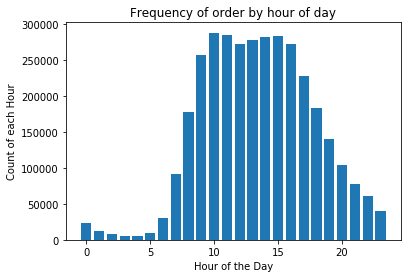

In [18]:
plt.bar(count.index,count.values)
plt.xlabel("Hour of the Day")
plt.ylabel("Count of each Hour")
plt.title("Frequency of order by hour of day")
plt.show()

From above graph it can be seen that majority of orders are made during the day time

Finding the distribution of Day of Week v\s Hour of the Day

In [19]:
grouped=orders.groupby(['order_dow','order_hour_of_day'])['order_number'].aggregate("count").reset_index()
grouped=grouped.pivot('order_dow','order_hour_of_day','order_number') 
#pivot() produces a table with index=order_dow,columns=order_hour_of_day and values=order_number
print(grouped)

order_hour_of_day    0     1     2    3    4     5     6      7      8   \
order_dow                                                                 
0                  3936  2398  1409  963  813  1168  3329  12410  28108   
1                  3674  1830  1105  748  809  1607  5370  16571  34116   
2                  3059  1572   943  719  744  1399  4758  13245  24635   
3                  2952  1495   953  654  719  1355  4562  12396  22553   
4                  2642  1512   899  686  730  1330  4401  12493  21814   
5                  3189  1672  1016  841  910  1574  4866  13434  24015   
6                  3306  1919  1214  863  802  1136  3243  11319  22960   

order_hour_of_day     9   ...      14     15     16     17     18     19  \
order_dow                 ...                                              
0                  40798  ...   54552  53954  49463  39753  29572  22654   
1                  51908  ...   46764  46403  44761  36792  28977  22145   
2                  3

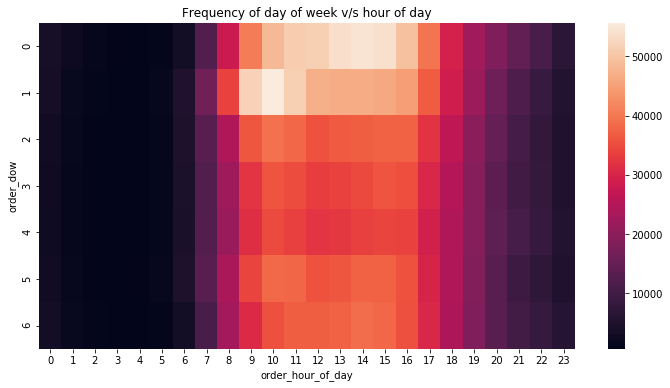

In [20]:
plt.figure(figsize=(12,6))
sns.heatmap(grouped)
plt.title("Frequency of day of week v/s hour of day")
plt.show()

order_dow=0 represents Saturday and order_dow=1 represents Sunday. So maximum orders seem to be placed on Saturday evening and Sunday morning.

Finding time interval between orders

In [21]:
count=orders.days_since_prior_order.value_counts()
print(count)

30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
2.0     193206
8.0     181717
1.0     145247
9.0     118188
14.0    100230
10.0     95186
13.0     83214
11.0     80970
12.0     76146
0.0      67755
15.0     66579
16.0     46941
21.0     45470
17.0     39245
20.0     38527
18.0     35881
19.0     34384
22.0     32012
28.0     26777
23.0     23885
27.0     22013
24.0     20712
25.0     19234
29.0     19191
26.0     19016
Name: days_since_prior_order, dtype: int64


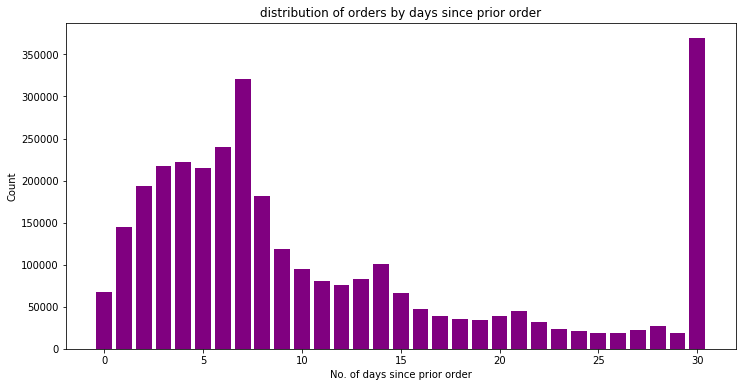

In [22]:
plt.figure(figsize=(12,6))
plt.bar(count.index,count.values,color="purple")
plt.xlabel("No. of days since prior order")
plt.ylabel("Count")
plt.title("distribution of orders by days since prior order")
plt.show()

It can be seen that most reorders are once in a week or once in a month as peaks at x=7 and x=30 are highest among others.

Finding percentage of reorders in prior dataset,i.e. no. of products that are re-ordered 

In [23]:
order_products__prior.reordered.sum()/order_products__prior.shape[0] #no. of reorders/total no. of orders

0.5896974667922161

Finding percentage of reorders in train dataset ,i.e. no. of products that are re-ordered

In [24]:
order_products__train.reordered.sum()/order_products__train.shape[0] #no. of reorders/total no. of orders

0.5985944127509629

It can be seen that 59% of products in an order are re-ordered

Finding no. of re-orders and no re-orders

In [25]:
grouped=order_products__prior.groupby('order_id')["reordered"].aggregate("sum").reset_index()
grouped["reordered"].loc[grouped["reordered"]>=1]=1
grouped.reordered.value_counts()/grouped.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

12% of orders have no re-orders in prior set

In [26]:
grouped=order_products__train.groupby('order_id')["reordered"].aggregate("sum").reset_index()
grouped["reordered"].loc[grouped["reordered"]>=1]=1
grouped.reordered.value_counts()/grouped.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

6% of orders have no re-orders in train set

Finding no. of products in each order

In [27]:
grouped=order_products__train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
count=grouped.add_to_cart_order.value_counts()
print(count.head())

5    8895
6    8708
7    8541
4    8218
3    8033
Name: add_to_cart_order, dtype: int64


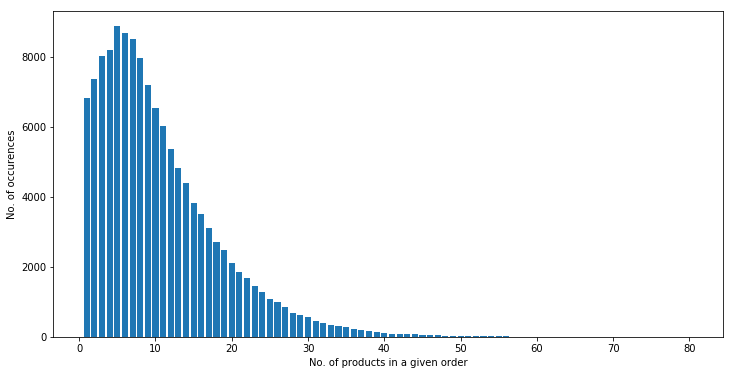

In [28]:
plt.figure(figsize=(12,6))
plt.bar(count.index,count.values)
plt.xlabel("No. of products in a given order")
plt.ylabel("No. of occurences")
plt.show()

Maximum value is at 5 that means mostly there are 5 products in a given order